In [1]:
import os
import glob
import random
import getpass
import numpy as np
import torch
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import open3d as o3d
import plotly.graph_objects as go
import sys
sys.path.append(os.getcwd())
sys.path.append(os.path.dirname(os.getcwd()))

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Train/Valid Datasets

In [2]:
# CHANGRABLE VARIABLES
DATASET_DIR = r"D:\Datasets\MinimarketPointCloud\MiniMarket_point_clouds\2048\segmentation_dataset\ketchup_heinz_400ml_segmentation_20250526_121710_numPoints_2048_maxObjects_10_orientations_1.h5"
# MODEL
from item_pointnet2_torch import PointNet2_SegHead
weights_path = r"C:\Users\jorge\OneDrive - University of Edinburgh\DissertationProject\diss\MiniMarket_dataset_segmentation\PointNet2_object_segmentation_modelspointnet2_ketchup_heinz_400ml_1200_4096_segmentation_40960_1200.h5_seg_model_9.pth"
model_head = PointNet2_SegHead()

In [3]:
def get_point_cloud(DATASET_DIR, N):
    with h5py.File(DATASET_DIR, 'r') as f:
        # Read datasets
        points_sample = f["seg_points"][:]  
        colors_sample = f["seg_colors"][:]  
        seg_labels = f["seg_labels"][:]  
    print(points_sample.shape)
    print(colors_sample.shape)
    print(seg_labels.shape)
    
    print("Random sample index:", N)
    points_sample = points_sample[N, :, :]
    colors_sample = colors_sample[N, :, :]
    labels_sample = np.where((seg_labels[N, :, :] == np.array([1, 0])).all(axis=1, keepdims=True), [0, 1, 0], [1, 0, 0])
    return points_sample, colors_sample, labels_sample

def matplotlib_pc(points_sample, colors_sample, labels_sample):

    fig = plt.figure(figsize=(12, 6))

    # First subplot for color visualization
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(points_sample[:, 0], points_sample[:, 1], points_sample[:, 2],
                c=colors_sample, s=1)
    ax1.set_title("Color Visualization")
    ax1.set_axis_off()

    # Second subplot for label visualization
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(points_sample[:, 0], points_sample[:, 1], points_sample[:, 2],
                c=labels_sample, s=1)
    ax2.set_title("Label Visualization")
    ax2.set_axis_off()

    plt.show()

def open3d_pc(points_sample, colors_sample, labels_sample):
    pcd_colors = o3d.geometry.PointCloud()
    pcd_colors.points = o3d.utility.Vector3dVector(points_sample)
    pcd_colors.colors = o3d.utility.Vector3dVector(colors_sample)
    o3d.visualization.draw_geometries([pcd_colors], window_name="Color Visualization")

    pcd_labels = o3d.geometry.PointCloud()
    pcd_labels.points = o3d.utility.Vector3dVector(points_sample)
    pcd_labels.colors = o3d.utility.Vector3dVector(labels_sample)
    o3d.visualization.draw_geometries([pcd_labels], window_name="Label Visualization")

def model_pred(model, weights_path, dataset_sample):
    
    # Load the model
    model_weights = torch.load(weights_path)

    # Load the state dictionary into the model
    model.load_state_dict(model_weights)
    model.eval()

    # Convert dataset_samples to a PyTorch tensor and move it to the appropriate device
    dataset_samples_tensor = torch.tensor(dataset_sample, dtype=torch.float32).to("cpu")
    print(dataset_samples_tensor.shape)
    # Perform inference
    logits = model(dataset_samples_tensor)[0]
    output = torch.argmin(logits, dim=2)
    print(output.shape)
    return output


def plot_preds_matplotlib(points_sample, labels_sample, output):
    fig = plt.figure(figsize=(12, 6))

    # first subplot for label visualization
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(points_sample[:, 0], points_sample[:, 1], points_sample[:, 2],
                c=labels_sample, s=1)
    ax1.set_title("Label Visualization")
    ax1.set_axis_off()

    # Second subplot for label visualization
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(points_sample[:, 0], points_sample[:, 1], points_sample[:, 2],
                c=output, s=1)
    ax2.set_title("Label Visualization")
    ax2.set_axis_off()
    plt.show()

def plot_preds_open3d(points_sample, labels_sample, output):
        
    pcd_labels = o3d.geometry.PointCloud()
    pcd_labels.points = o3d.utility.Vector3dVector(points_sample)
    pcd_labels.colors = o3d.utility.Vector3dVector(labels_sample)
    o3d.visualization.draw_geometries([pcd_labels], window_name="Label Visualization")

    pcd_labels = o3d.geometry.PointCloud()
    pcd_labels.points = o3d.utility.Vector3dVector(points_sample)
    # Map the output tensor to RGB colors (e.g., 0 -> red, 1 -> green)
    output_colors = np.where(output.T.numpy() == 0, [1, 0, 0], [0, 1, 0])  # Red for 0, Green for 1
    pcd_labels.colors = o3d.utility.Vector3dVector(output_colors)
    o3d.visualization.draw_geometries([pcd_labels], window_name="Label Visualization")


(1200, 20480, 3)
(1200, 20480, 3)
(1200, 20480, 2)
Random sample index: 1


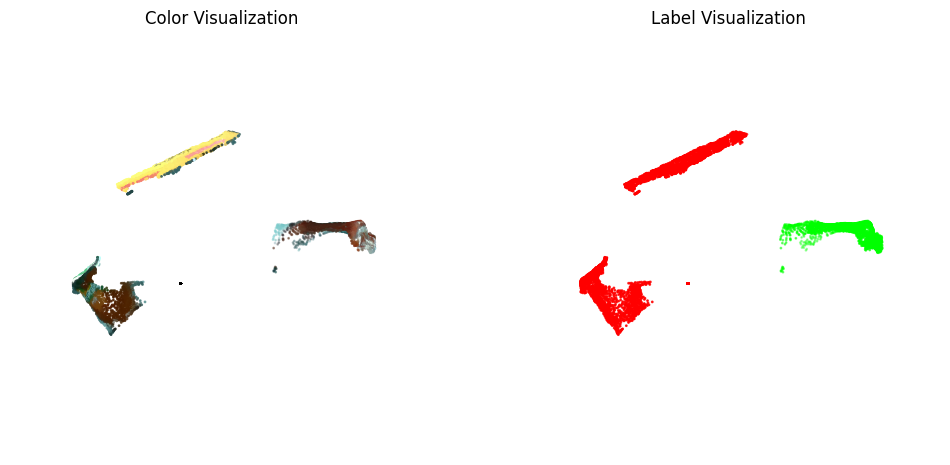

In [4]:
points_sample, colors_sample, labels_sample = get_point_cloud(DATASET_DIR, 1)
matplotlib_pc(points_sample, colors_sample, labels_sample)
# open3d_pc(points_sample, colors_sample, labels_sample)

torch.Size([1, 6, 20480])
torch.Size([1, 20480])


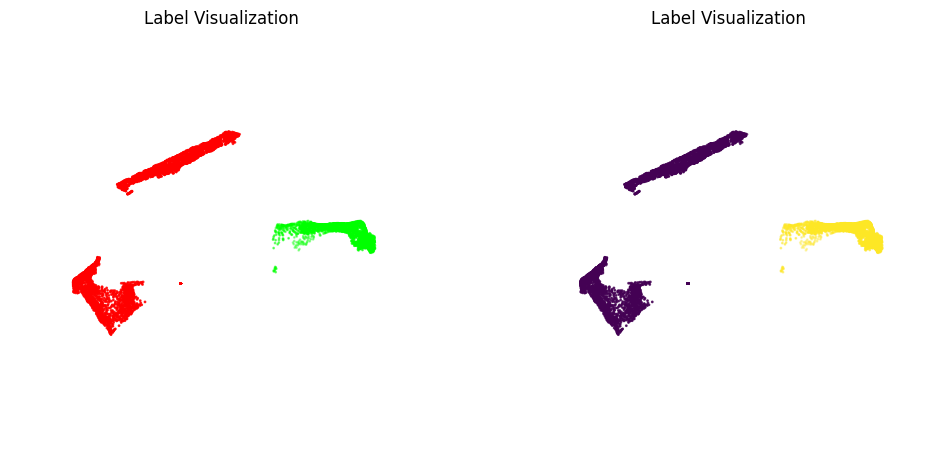

In [5]:
dataset_sample = np.concatenate((points_sample, colors_sample), axis=1).T[np.newaxis, :]
preds = model_pred(model_head, weights_path, dataset_sample)
plot_preds_matplotlib(points_sample, labels_sample, preds)
plot_preds_open3d(points_sample, labels_sample, preds)

# TEST

In [6]:
# CHANGRABLE VARIABLES
PC_SELECTED = 4  # Change this to visualize different scenes
percentage = 0.1 # Take a percentage of points, e.g., 10%
DATASET_DIR = r"D:\Datasets\MinimarketPointCloud\MiniMarket_point_clouds\test\all_test_scenes.h5"
                        # MODEL
from item_pointnet2_torch import PointNet2_SegHead
weights_path = r"C:\Users\jorge\OneDrive - University of Edinburgh\DissertationProject\diss\MiniMarket_dataset_segmentation\PointNet2_object_segmentation_modelspointnet2_ketchup_heinz_400ml_1200_4096_segmentation_40960_1200.h5_seg_model_9.pth"
model_head = PointNet2_SegHead()

In [7]:
def get_point_cloud(DATASET_DIR, PC_SELECTED,percentage=1):

    with h5py.File(DATASET_DIR, 'r') as f:
        # Read datasets
        points_sample = f["point_clouds"][:][PC_SELECTED]
        colors_sample = f["color_clouds"][:][PC_SELECTED]
        valid_mask = ~np.isnan(points_sample).any(axis=1) & ~np.isnan(colors_sample).any(axis=1)
        points_sample = points_sample[valid_mask]
        colors_sample = colors_sample[valid_mask]
        seg_points_mean = np.nanmean(points_sample, axis=0)
        points_sample = points_sample - seg_points_mean
        points_sample = np.nan_to_num(points_sample, nan=0.0)
        colors_sample = np.nan_to_num(colors_sample, nan=0.0)
    num_points = int(points_sample.shape[0] * percentage)
    indices = np.random.choice(points_sample.shape[0], num_points, replace=False)
    points_sample = points_sample[indices]
    colors_sample = colors_sample[indices]
    return points_sample, colors_sample

def matplotlib_pc(points_sample, colors_sample):
    fig = plt.figure(figsize=(12, 6))

    # First subplot for color visualization
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(points_sample[:, 0], points_sample[:, 1], points_sample[:, 2],
                c=colors_sample, s=1)
    ax1.set_title("Color Visualization")
    ax1.set_axis_off()

    plt.show()

def open3d_pc(points_sample, colors_sample):
    pcd_colors = o3d.geometry.PointCloud()
    pcd_colors.points = o3d.utility.Vector3dVector(points_sample)
    pcd_colors.colors = o3d.utility.Vector3dVector(colors_sample)
    o3d.visualization.draw_geometries([pcd_colors], window_name="Color Visualization")

def model_pred(model, weights_path, dataset_sample,threshold=0.5):
    # Load the model
    model_weights = torch.load(weights_path)
    # Load the state dictionary into the model
    model.load_state_dict(model_weights)
    model.eval()
    dataset_samples_tensor = torch.tensor(dataset_sample, dtype=torch.float32).to("cpu")
    print(dataset_samples_tensor.shape)
    # Perform inference
    logits = model(dataset_samples_tensor)[0]
    print(logits.shape)
    print(torch.softmax(logits, dim=2).shape)
    output = (torch.softmax(logits, dim=2)[:,:, 0] > threshold).int()
    return output

def plot_preds_matplotlib(points_sample, output):
    fig = plt.figure(figsize=(12, 6))

    # first subplot for label visualization
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(points_sample[:, 0], points_sample[:, 1], points_sample[:, 2],
                c=colors_sample, s=1)
    ax1.set_title("Color Visualization")
    ax1.set_axis_off()

    # Second subplot for label visualization
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(points_sample[:, 0], points_sample[:, 1], points_sample[:, 2],
                c=output, s=1)
    ax2.set_title("Prediction Visualization")
    ax2.set_axis_off()
    plt.show()

def plot_preds_open3d(points_sample, output):
    pcd_colors = o3d.geometry.PointCloud()
    pcd_colors.points = o3d.utility.Vector3dVector(points_sample)
    pcd_colors.colors = o3d.utility.Vector3dVector(colors_sample)
    o3d.visualization.draw_geometries([pcd_colors], window_name="Color Visualization")

    pcd_labels = o3d.geometry.PointCloud()
    pcd_labels.points = o3d.utility.Vector3dVector(points_sample)
    # Map the output tensor to RGB colors (e.g., 0 -> red, 1 -> green)
    output_colors = np.where(output.T.numpy() == 0, [1, 0, 0], [0, 1, 0])  # Red for 0, Green for 1
    pcd_labels.colors = o3d.utility.Vector3dVector(output_colors)
    o3d.visualization.draw_geometries([pcd_labels], window_name="Label Visualization")


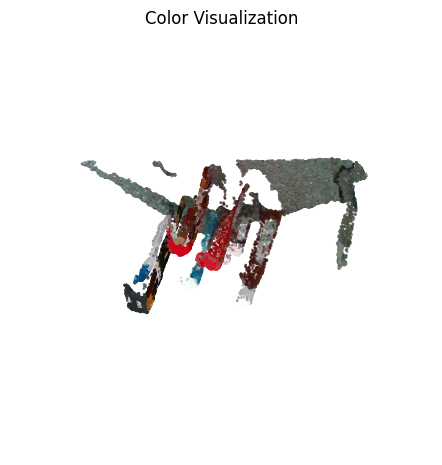

In [8]:
points_sample, colors_sample = get_point_cloud(DATASET_DIR, PC_SELECTED,percentage)
matplotlib_pc(points_sample, colors_sample)
open3d_pc(points_sample, colors_sample)

torch.Size([1, 6, 32434])
torch.Size([1, 32434, 2])
torch.Size([1, 32434, 2])


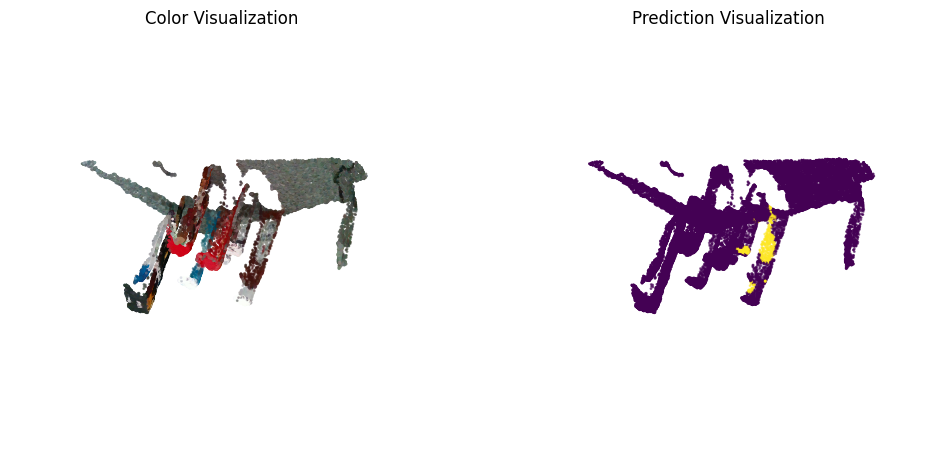

In [9]:
dataset_sample = np.concatenate((points_sample, colors_sample), axis=1).T[np.newaxis, :]
preds = model_pred(model_head, weights_path, dataset_sample,threshold=0.2)
plot_preds_matplotlib(points_sample, preds)
# plot_preds_open3d(points_sample, preds)

In [10]:
plot_preds_open3d(points_sample, preds)